In [217]:
# import necessary packages
import plotly.graph_objects as go
import pandas as pd
import plotly.express as px

In [159]:
# load data

df = pd.read_csv("rels_sample.csv")
df.head()

/var/folders/tw/3wzvw38122z72njtkggxtt6m0000gn/T/ipykernel_34121/440955792.py:3: DtypeWarning:

Columns (12,16) have mixed types. Specify dtype option on import or set low_memory=False.



,node_id_start,node_id_end,rel_type,link,sourceID,address_start,name_start,countries_start,country_codes_start,sourceID_start,...,jurisdiction_description_end,company_type_end,internal_id_end,incorporation_date_end,inactivation_date_end,struck_off_date_end,dorm_date_end,status_end,service_provider_end,ibcRUC_end
0,23000436,20111548,intermediary_of,intermediary of,Bahamas Leaks,NaN,UNIVERSAL LEGAL SERVICES,Bahamas,BHS,Bahamas Leaks,...,Bahamas,NaN,111548.0,17-JUL-2000,NaN,31-AUG-2002,NaN,NaN,NaN,111548B
1,23000246,20050981,intermediary_of,intermediary of,Bahamas Leaks,NaN,"SMITH, SMITH & COMPANY",Bahamas,BHS,Bahamas Leaks,...,Bahamas,NaN,50981.0,19-DEC-1996,NaN,01-JAN-1998,NaN,NaN,NaN,50981B
2,56008636,58080065,registered_address,registered address,Paradise Papers - Malta corporate registry,NaN,FLORIAN BREGASI,Albania,ALB,Paradise Papers - Malta corporate registry,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,110020422,110088539,same_name_as,same name as,NaN,NaN,WARD BRIAN C.,NaN,NaN,Paradise Papers - Barbados corporate registry,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,12171472,12180735,similar,similar name and address as,NaN,NaN,XU FENG,China,CHN,Panama Papers,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [160]:
top_jurisdictions = (
    df[df['node_type_end'] == 'entity']['jurisdiction_description_end']
    .value_counts()
    .nlargest(5)
    .index
    .tolist()
)

df_filtered = df[
    (df['node_type_start'] == 'officer') & 
    (df['node_type_end'] == 'entity') &
    (df['jurisdiction_description_end'].isin(top_jurisdictions))
]

In [161]:
print(df_filtered['jurisdiction_description_end'].value_counts())

jurisdiction_description_end
Malta                     84806
British Virgin Islands    58990
Bermuda                   24656
Barbados                  21284
Bahamas                    7970
Name: count, dtype: int64


In [162]:
print(top_jurisdictions)

['Malta', 'British Virgin Islands', 'Bahamas', 'Bermuda', 'Barbados']


In [163]:
juris_counts = (
    df_filtered[df_filtered['jurisdiction_description_end'].isin(top_jurisdictions)]
    ['jurisdiction_description_end']
    .value_counts()
    .reset_index()
)

juris_counts.columns = ['jurisdiction', 'count']
print(juris_counts)

             jurisdiction  count
0                   Malta  84806
1  British Virgin Islands  58990
2                 Bermuda  24656
3                Barbados  21284
4                 Bahamas   7970


In [185]:
df_filtered['countries_start'] = df_filtered['countries_start'].fillna("").astype(str)
df_filtered['countries_start'] = df_filtered['countries_start'].str.split(';')
df_filtered = df_filtered.explode('countries_start')

df_filtered['countries_start'] = df_filtered['countries_start'].str.strip()

df_filtered = df_filtered[df_filtered['countries_start'] != ""]

df_filtered = df_filtered[
    (df_filtered['countries_start'].str.lower() != "not identified") &
    (df_filtered['countries_start'] != "")
]
country_counts = df_filtered['countries_start'].value_counts().reset_index()
country_counts.columns = ['country', 'count']

print(country_counts.head(10))

                  country  count
0                   Malta  58394
1          United Kingdom  14592
2  British Virgin Islands  11171
3           United States  11108
4                 Bermuda   9815
5               Hong Kong   8816
6               Singapore   8683
7               Indonesia   7317
8                   China   6927
9                Thailand   6219


In [186]:
flow_counts = df_filtered.groupby(['countries_start', 'jurisdiction_description_end']).size().reset_index(name='count')

top_jurisdictions = ['Malta', 'British Virgin Islands', 'Bahamas', 'Bermuda', 'Barbados']
flow_counts = flow_counts[flow_counts['jurisdiction_description_end'].isin(top_jurisdictions)]

top_origins = (
    flow_counts.groupby('countries_start')['count']
    .sum()
    .nlargest(10)
    .index
    .tolist()
)
labels = list(top_origins) + [j for j in top_jurisdictions if j not in top_origins]
label_to_index = {label: i for i, label in enumerate(labels)}

flow_counts['source'] = flow_counts['countries_start'].map(label_to_index)
flow_counts['target'] = flow_counts['jurisdiction_description_end'].map(label_to_index)


In [187]:
print(flow_counts['jurisdiction_description_end'].value_counts())

jurisdiction_description_end
British Virgin Islands    208
Malta                     176
Bermuda                   129
Bahamas                   114
Barbados                    5
Name: count, dtype: int64


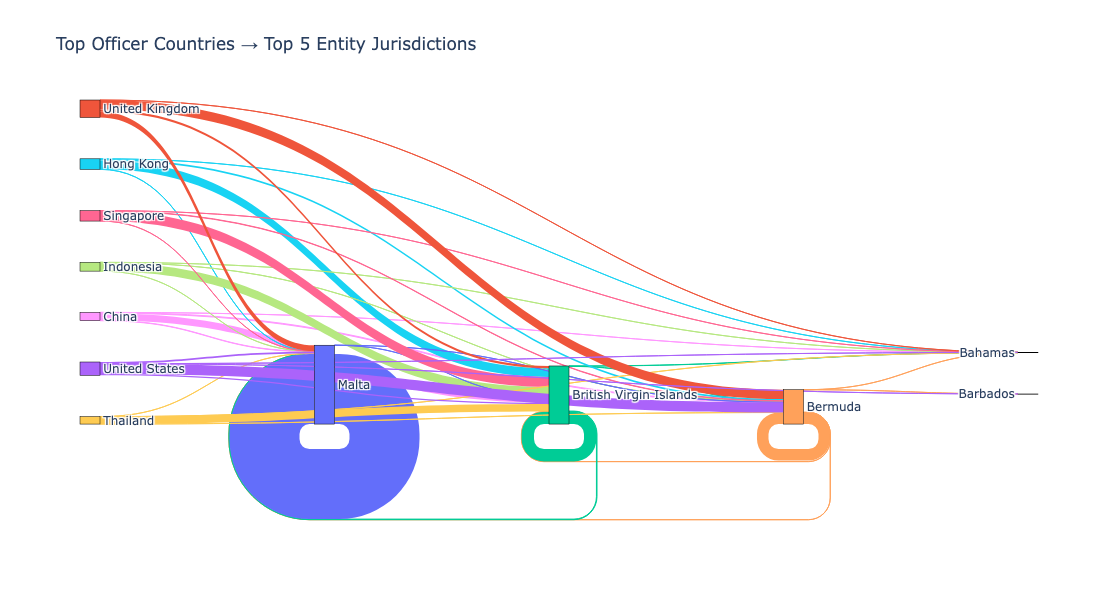

In [218]:
colors = px.colors.qualitative.Plotly

origin_color_map = {country: colors[i % len(colors)] for i, country in enumerate(top_origins)}

flow_counts = flow_counts[
    flow_counts['countries_start'].isin(top_origins) &
    flow_counts['jurisdiction_description_end'].isin(top_jurisdictions)
]

flow_counts['link_color'] = flow_counts['countries_start'].map(origin_color_map)

labels = list(top_origins) + top_jurisdictions
label_to_index = {label: i for i, label in enumerate(labels)}

node_colors = [origin_color_map.get(label, "lightgray") for label in labels]

fig = go.Figure(data=[go.Sankey(
    node=dict(
        pad=30,
        thickness=20,
        line=dict(color="black", width=0.5),
        label=labels,
        color=node_colors
    ),
    link=dict(
        source=flow_counts['countries_start'].map(label_to_index),
        target=flow_counts['jurisdiction_description_end'].map(label_to_index),
        value=flow_counts['count'],
        color=flow_counts['link_color']
    )
)])

fig.update_layout(
    title_text="Top Officer Countries → Top 5 Entity Jurisdictions",
    font=dict(size=12),
    height=600,
    width=1000
)
fig.show()

In [216]:
summary_table = (
    flow_counts.groupby(['countries_start', 'jurisdiction_description_end'])['count']
    .sum()
    .reset_index()
)

summary_table['proportion'] = summary_table.groupby('countries_start')['count'].transform(
    lambda x: x / x.sum()
)

summary_table['proportion'] = (summary_table['proportion'] * 100).round(2)

print(summary_table)

           countries_start jurisdiction_description_end  count  proportion
0                  Bermuda                      Bahamas      1        0.01
1                  Bermuda                     Barbados      1        0.01
2                  Bermuda                      Bermuda   9596       97.77
3                  Bermuda       British Virgin Islands    164        1.67
4                  Bermuda                        Malta     53        0.54
5   British Virgin Islands                      Bahamas    148        1.32
6   British Virgin Islands                      Bermuda    190        1.70
7   British Virgin Islands       British Virgin Islands  10356       92.70
8   British Virgin Islands                        Malta    477        4.27
9                    China                      Bahamas     20        0.29
10                   China                      Bermuda    663        9.57
11                   China       British Virgin Islands   5915       85.39
12                   Chin